# 词向量探索之旅

### 环境准备

确保已将 `histwords` 目录加入 `PYTHONPATH`，并已安装依赖。


In [1]:
import sys
sys.path.append('/root/workspace/MicroDistance-Word2Vec/histwords')
import pickle
import numpy as np
from itertools import combinations
from numpy.linalg import norm
from representations.sequentialembedding import SequentialEmbedding
from representations.embedding import Embedding

## 1. 从斯坦福大学HistWords项目中获取词向量

In [7]:
import pickle
import numpy as np

# 加载词表
with open('/root/workspace/MicroDistance-Word2Vec/Chinese_sgns_basic/1990-vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# 加载词向量
vecs = np.load('/root/workspace/MicroDistance-Word2Vec/Chinese_sgns_basic/1990-w.npy')

# 获取某个词的向量
words = ['病毒', '电脑', '疾病', '计算机']
for word in words:
    if word in vocab:
        idx = vocab.index(word)
        vector = vecs[idx]
        print(vector.shape) # 输出向量维度
    else:
        print('词不在词表中')
        


(300,)
(300,)
(300,)
(300,)


In [8]:
from itertools import combinations
from numpy.linalg import norm

# 获取所有在词表中的词及其向量
word_vecs = {}
for word in words:
    if word in vocab:
        idx = vocab.index(word)
        word_vecs[word] = vecs[idx]

# 计算两两余弦相似度
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

for w1, w2 in combinations(word_vecs.keys(), 2):
    sim = cosine_similarity(word_vecs[w1], word_vecs[w2])
    print(f"{w1} - {w2} 的余弦相似度: {sim:.4f}")


病毒 - 电脑 的余弦相似度: 0.2628
病毒 - 疾病 的余弦相似度: 0.3643
病毒 - 计算机 的余弦相似度: 0.3050
电脑 - 疾病 的余弦相似度: 0.1756
电脑 - 计算机 的余弦相似度: 0.4383
疾病 - 计算机 的余弦相似度: 0.1918


## 调用HistWords提供的API端口

In [ ]:
from representations.sequentialembedding import SequentialEmbedding
from representations.embedding import Embedding
# SequentialEmbedding是Word2Vec（SGNS）词向量
# Embedding是SVD词向量

# 加载词向量：单一时间点
embedding = Embedding.load('/root/workspace/MicroDistance-Word2Vec/Chinese_sgns_basic/1990')
# 获取词向量
vector = embedding.represent('病毒')
print(vector.shape)

(300,)


In [10]:
neighbors = embedding.closest('学者', n=5)
for score, word in neighbors:
    print(word, score)

学者 0.9999999999999999
专家 0.6019439454234679
名望 0.5160167174959029
业内 0.49601799256692675
与会 0.45654864865628536


## 历史模型

In [11]:
### 3.1 加载历史词向量序列

from representations.sequentialembedding import SequentialEmbedding
years = range(1950, 2000, 10)
semb = SequentialEmbedding.load('/root/workspace/MicroDistance-Word2Vec/chi-sim-all/sgns', years)

In [12]:
### 3.2 获取某一年份的 Embedding

embed_1990 = semb.get_embed(1990)

In [13]:
### 3.3 获取某个词在各年份的向量

for year in years:
    vec = semb.get_embed(year).represent('主义')
    print(year, vec[:5])

1950 [-0.04487927  0.02573186 -0.00947995 -0.03877381  0.03205856]
1960 [ 0.00161559  0.04229061 -0.0445441  -0.02257752  0.06220378]
1970 [-0.00346575  0.0531096  -0.09491494 -0.03063736  0.01986805]
1980 [-0.00850022 -0.02292808 -0.06003177 -0.04335207  0.04974374]
1990 [-0.01324701  0.0365957   0.01875553 -0.0736503   0.09564648]


In [14]:
### 3.4 计算某两个词随时间的相似度变化

time_sims = semb.get_time_sims('学术', '反动')
for year, sim in time_sims.items():
    print(year, sim)

1950 0.4552571961323729
1960 0.4420168275879869
1970 0.1762702730146145
1980 0.12860420820157537
1990 0.1581925143538493


In [15]:
### 3.5 获取某个词在所有年份的邻居集合

neigh_set = semb.get_seq_neighbour_set('反动', n=2)
print(neigh_set)

{'猖狂', '反动', '腐朽', '残酷', '流毒', '资产'}


## 读取词性

In [16]:
import pickle

pos_file = '/root/workspace/MicroDistance-Word2Vec/chi-sim-all/pos/1990-pos.pkl'
with open(pos_file, 'rb') as f:
    pos_dict = pickle.load(f)

# 示例：提取指定词的词性
target_words = ['文人', '作家', '反动']
for word in target_words:
    print(f"{word}: {pos_dict.get(word, '未知')}")

文人: NOUN
作家: NOUN
反动: ADJ


### 词性标签表

| 类别       | NOUN | VERB | ADV | ADJ | PRT           | NUM |
|------------|------|------|-----|------|---------|-----|
| 含义 | 名词 | 动词 | 副词 | 形容词 | 小品词| 数词 |



In [2]:
# 按照词性筛选邻居

def get_neighbor_with_pos(embed: Embedding, pos_dict: dict, target_word: str, target_pos: str, n=10):
    """
    获取与 target_word 最相近且词性为 target_pos 的前 n 个词。
    """
    # 获取所有邻居及分数
    neighbors = embed.closest(target_word, n=n*5)  # 先多取一些，防止词性过滤后不够
    filtered = []
    for score, word in neighbors:
        if pos_dict.get(word) == target_pos:
            filtered.append((score, word))
        if len(filtered) >= n:
            break
    return filtered


In [ ]:
# 示例用法：
result = get_neighbor_with_pos(embedding, pos_dict, '反动', 'NOUN', n=5)
for score, word in result:
    print(word, score)

In [18]:
# 获取历年的邻居集合（不筛选词性）

semb.get_seq_closest_by_year("钱", n=5)

{1950: [(0.9999999999999998, '钱'),
  (0.9038659420271383, '花'),
  (0.835149942616815, '人家'),
  (0.8337984704298391, '买'),
  (0.8294886079513678, '吃')],
 1960: [(1.0, '钱'),
  (0.7650870282192708, '花'),
  (0.7129815339097929, '一声'),
  (0.6971985912410859, '口气'),
  (0.6760362568782627, '这儿')],
 1970: [(0.9999999999999993, '钱'),
  (0.5850082522695432, '买'),
  (0.5524397898584145, '笔'),
  (0.5367441157010124, '花'),
  (0.5156797911524045, '力气')],
 1980: [(1.0, '钱'),
  (0.5349853096138412, '赚'),
  (0.5055068782570069, '花'),
  (0.47393366638954987, '袋'),
  (0.471501573268131, '琛')],
 1990: [(1.0, '钱'),
  (0.4587084023580492, '袋'),
  (0.45845257084407204, '掏'),
  (0.44759882378635524, '赚'),
  (0.4351914162230578, '抽屉')]}

In [2]:
def get_seq_neighbor_with_pos(seqembed: SequentialEmbedding, pos_dict: dict, target_word: str, target_pos: str, n=10):
    """
    获取目标词在每个年份中，最相近且词性为 target_pos 的前 n 个词。
    返回格式：{year: [(score, word), ...], ...}
    """
    result = {}
    for year, embed in seqembed.embeds.items():
        neighbors = embed.closest(target_word, n=n*100)  # 先多取一些
        filtered = []
        for score, word in neighbors:
            if pos_dict.get(word) == target_pos and word != target_word:
                filtered.append((score, word))
            if len(filtered) >= n:
                break
        result[year] = filtered
    return result

In [20]:
# 示例用法
get_seq_neighbor_with_pos(semb, pos_dict, "钱", "ADJ", n=5)

{1950: [(0.7484916568501956, '年轻'),
  (0.698449745027883, '女'),
  (0.5980052306407435, '亲爱'),
  (0.5614793955077362, '违法'),
  (0.5436568614143564, '间接')],
 1960: [(0.5316574658520359, '女'),
  (0.5078091283696169, '年轻'),
  (0.4924626804071737, '相关'),
  (0.4663310115925252, '亲爱'),
  (0.4641558590600444, '有限')],
 1970: [(0.4098309110734928, '男'),
  (0.3945802598299771, '女'),
  (0.3754188716391379, '年轻'),
  (0.3684000505355881, '优质'),
  (0.35792361677380874, '可怜')],
 1980: [(0.3748411423736513, '巨额')],
 1990: [(0.2683090578396913, '余下')]}

## 读取词频（如果你需要的话）

In [21]:
counts_file = '/root/workspace/MicroDistance-Word2Vec/chi-sim-all/counts/1990-counts.pkl'
with open(counts_file, 'rb') as f:
    counts_dict = pickle.load(f, encoding='latin1') # 考虑到是python2时代保存的pickle文件，应该用latin1读取避免历史遗留问题

# 示例：提取指定词的词频
target_words = ['文人', '作家', '反动']
for word in target_words:
    print(f"{word}: {counts_dict.get(word, '未知')}")
    
# 如果你需要读取多个年代的词频，可自行编写相关代码

文人: 2076.0
作家: 210922.5
反动: 44264.5


## 加载数据集代码总结

In [22]:
# 如果读取单个时间点的数据：

# from representations.embedding import Embedding
# from representations.sequentialembedding import SequentialEmbedding

# embedding = Embedding.load('这里放你的路径')


# 如果读取多个时间点的数据：

# years = range(1950, 2000, 10) # 这里放年份列表
# semb = SequentialEmbedding.load('这里放你的文件夹路径', years)

## 英文数据集的加载也同理

In [3]:
from representations.sequentialembedding import SequentialEmbedding
from representations.embedding import Embedding

years = range(1870,2000,10)
seq_embedding_eng = SequentialEmbedding.load('/root/workspace/MicroDistance-Word2Vec/eng-all/sgns',years)
# 加载比较慢，要忍一下

In [26]:
seq_embedding_eng.get_seq_closest_by_year("sociology", n=5)

{1900: [(0.9999999999999997, 'sociology'),
  (0.6100873679120147, 'civics'),
  (0.59094659142378, 'economics'),
  (0.5803837226064144, 'psychology'),
  (0.5774356863991916, 'ethics')],
 1910: [(1.0000000000000004, 'sociology'),
  (0.5445923625400886, 'economics'),
  (0.5195963119072255, 'anthropology'),
  (0.5128836317115731, 'psychology'),
  (0.4924609243782271, 'ethics')],
 1920: [(0.9999999999999999, 'sociology'),
  (0.5769480895455885, 'psychology'),
  (0.5252239773381819, 'biology'),
  (0.5077035258055832, 'economics'),
  (0.49882377234263653, 'anthropology')],
 1930: [(1.0, 'sociology'),
  (0.5761679124140623, 'anthropology'),
  (0.5475595988718008, 'psychology'),
  (0.5369074374825475, 'economics'),
  (0.49365685839561757, 'sociological')],
 1940: [(1.0000000000000004, 'sociology'),
  (0.549801421829228, 'psychology'),
  (0.5313390856919313, 'philosophy'),
  (0.5308933416838906, 'economics'),
  (0.5090065927768792, 'anthropology')],
 1950: [(0.9999999999999999, 'sociology'),
  (

In [10]:
eng_pos_file = '/root/workspace/MicroDistance-Word2Vec/eng-all/pos/1990-pos.pkl'
with open(eng_pos_file, 'rb') as f:
    eng_pos = pickle.load(f)

In [11]:
get_seq_neighbor_with_pos(seq_embedding_eng, eng_pos, 'sociology', 'ADJ', n=5)

{1870: [(0.35396117824294476, 'synthetic'),
  (0.352586732384496, 'magnetical'),
  (0.3365772650087527, 'polynesian'),
  (0.33645846555943804, 'darwinian'),
  (0.3325209577026794, 'biological')],
 1880: [(0.48180821961133424, 'sociological'),
  (0.40461391444439576, 'tactical'),
  (0.3591098137057118, 'theoretical'),
  (0.3551789340377014, 'psychological'),
  (0.35510544010823736, 'baconian')],
 1890: [(0.36518730565540414, 'psychological'),
  (0.3604906521603737, 'pedagogical'),
  (0.3369769272075456, 'biblical'),
  (0.33664236707334705, 'institutional'),
  (0.33576709094265744, 'political')],
 1900: [(0.3994272830241079, 'dynamic'),
  (0.38084152411844663, 'economic'),
  (0.3688548442798771, 'biological'),
  (0.36026568760270666, 'psychological'),
  (0.3563949067624349, 'humanistic')],
 1910: [(0.36514229107079077, 'political'),
  (0.3552880709011025, 'sociological'),
  (0.3449275269370676, 'dynamic'),
  (0.34312185374647897, 'social'),
  (0.33994407546445915, 'psychological')],
 192

In [17]:
import matplotlib.pyplot as plt

def plot_cosine_similarity(trend):
    plt.plot(list(trend.keys()), list(trend.values()), marker='o')
    plt.xlabel('Year')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


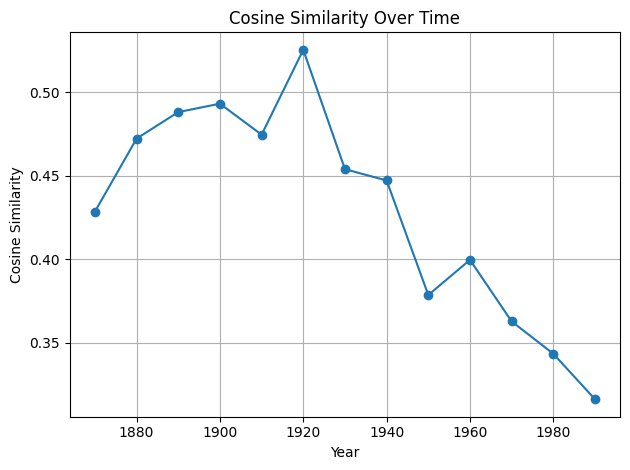

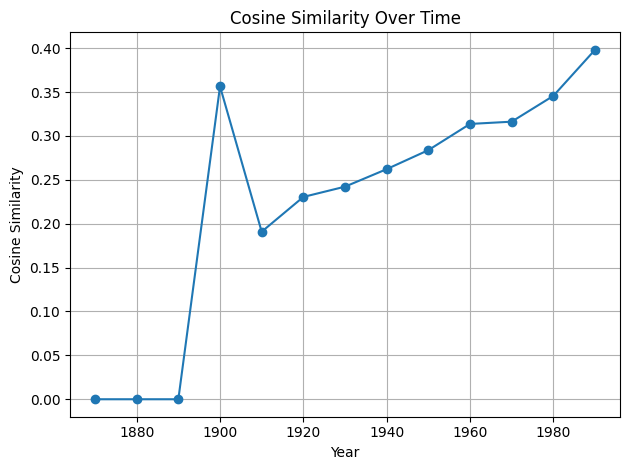

In [21]:
sims = seq_embedding_eng.get_time_sims('sociology','biology')
plot_cosine_similarity(sims)

sims = seq_embedding_eng.get_time_sims('sociology','humanistic')
plot_cosine_similarity(sims)


In [4]:
occupations = [
    "doctor", "lawyer", "teacher", "engineer", "nurse", "dentist", "accountant", "architect", "chemist", "scientist",
    "pilot", "farmer", "writer", "poet", "actor", "singer", "dancer", "musician", "painter", "sculptor",
    "tailor", "baker", "butcher", "barber", "clerk", "cashier", "waiter", "porter", "cook", "janitor",
    "soldier", "sailor", "captain", "guard", "officer", "detective", "judge", "minister", "priest", "monk",
    "hunter", "fisher", "miller", "weaver", "potter", "brewer", "carpenter", "mason", "plumber", "electrician",
    "mechanic", "driver", "miner", "merchant", "trader", "banker", "broker", "editor", "reporter", "librarian",
    "student", "scholar", "professor", "lecturer", "researcher", "mathematician", "physicist", "biologist", "geologist", "astronomer",
    "pharmacist", "optician", "surgeon", "therapist", "psychologist", "psychiatrist", "midwife", "paramedic", "firefighter", "policeman",
    "judge", "lawman", "warden", "blacksmith", "shoemaker", "tailor", "cobbler", "gardener", "cleaner", "washer",
    "vendor", "peddler", "bartender", "host", "usher", "receptionist", "clergyman", "chaplain", "bellhop", "waitress"
]

occupations_vecs = []

embed_1990 = seq_embedding_eng.get_embed(1990)

for occupation in occupations:
    vec = embed_1990.represent(occupation)
    occupations_vecs.append((occupation, vec))

('OOV: ', 'paramedic')
('OOV: ', 'firefighter')
('OOV: ', 'lawman')
('OOV: ', 'bellhop')


In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
def reduce_dims(occupations_vecs, method="pca"):
    """
    接收一个包含 (occupation, vector) 元组的列表，返回 DataFrame 结果
    参数：
        occupations_vecs: List[Tuple[str, np.ndarray]]
        method: "pca" 或 "tsne"
    返回：
        pd.DataFrame，包含列 ["occupation", "X", "Y"]
    """
    names = [item[0] for item in occupations_vecs]
    vecs = np.stack([item[1] for item in occupations_vecs])

    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    vecs_2d = reducer.fit_transform(vecs)
    return pd.DataFrame({"occupation": names, "X": vecs_2d[:, 0], "Y": vecs_2d[:, 1]})



In [6]:
import matplotlib.pyplot as plt

def plot_occupations_hexbin(df_proj, cmap="Blues"):
    """
    可视化二维职业向量（hexbin）
    参数：
        df_proj: DataFrame，包含列 ["occupation", "X", "Y"]
        cmap: 字符串，matplotlib colormap 名称
    """
    plt.figure(figsize=(6, 5))
    plt.hexbin(df_proj["X"], df_proj["Y"], cmap=cmap, gridsize=20, linewidths=0)
    plt.title("Occupations Projection")
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()


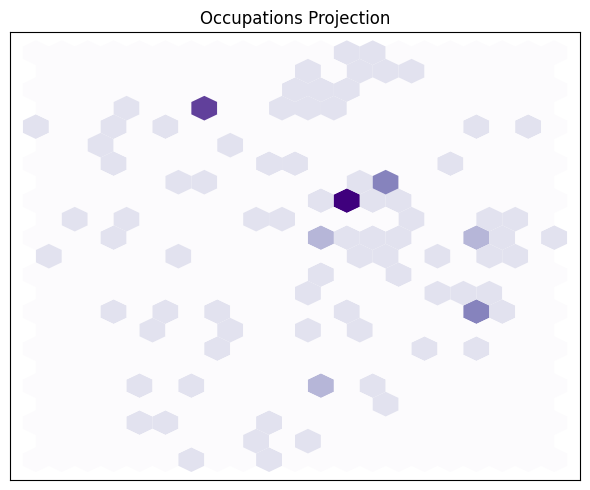

In [7]:
df_proj = reduce_dims(occupations_vecs, method="pca")  # 或 method="tsne"
plot_occupations_hexbin(df_proj, cmap="Purples")


In [14]:
from sklearn.cluster import KMeans

def cluster_occupations(occupations_vecs, n_clusters=6):
    """
    对职业向量进行 KMeans 聚类
    参数：
        occupations_vecs: List[Tuple[str, np.ndarray]]
        n_clusters: 聚类数量（默认 6）
    返回：
        pd.DataFrame，包含 occupation、X、Y、cluster 三列
    """
    names = [item[0] for item in occupations_vecs]
    vecs = np.stack([item[1] for item in occupations_vecs])

    # 降维到 2D 方便可视化
    pca = PCA(n_components=2)
    vecs_2d = pca.fit_transform(vecs)

    # 聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(vecs)

    df = pd.DataFrame({
        "occupation": names,
        "X": vecs_2d[:, 0],
        "Y": vecs_2d[:, 1],
        "cluster": clusters
    })

    return df, kmeans


In [9]:
def plot_clusters_with_labels(df_proj):
    """
    可视化聚类结果，带职业名称标注
    参数：
        df_proj: 包含 occupation、X、Y、cluster 列的 DataFrame
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_proj["X"], df_proj["Y"], c=df_proj["cluster"],
                          cmap="tab10", s=60, alpha=0.8)

    # 添加职业名称文本
    for _, row in df_proj.iterrows():
        plt.text(row["X"] + 0.01, row["Y"] + 0.01, row["occupation"],
                 fontsize=8, alpha=0.75)

    plt.title("Occupation Clusters with Labels")
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()


   occupation  cluster
      bellhop        0
       farmer        0
   blacksmith        0
       warden        0
    shoemaker        0
      butcher        0
       washer        0
      cobbler        0
       barber        0
        baker        0
  firefighter        0
         cook        0
       lawman        0
       porter        0
    paramedic        0
       hunter        0
        mason        0
    carpenter        0
       brewer        0
       potter        0
      peddler        0
        miner        0
       editor        0
     optician        0
       weaver        0
       miller        0
       fisher        0
       tailor        1
        clerk        1
       tailor        1
      cleaner        1
     waitress        1
     minister        1
        judge        1
      officer        1
        guard        1
      captain        1
      soldier        1
      janitor        1
       waiter        1
      cashier        1
        judge        1
    policem

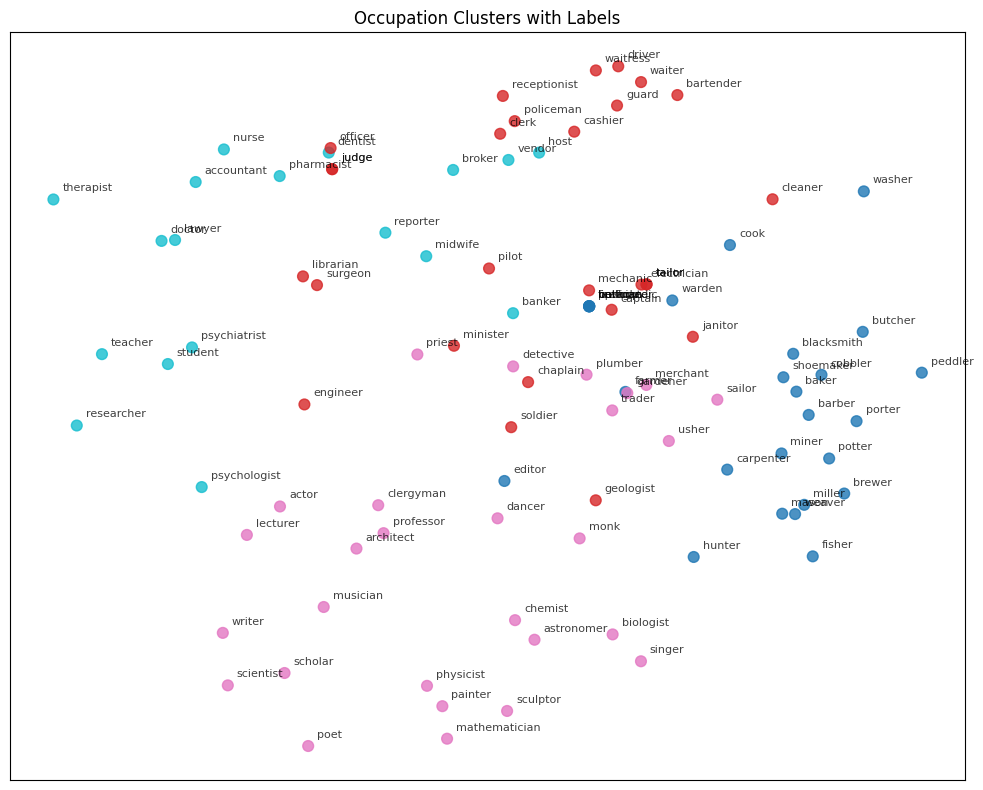

In [15]:
df_clustered, kmeans_model = cluster_occupations(occupations_vecs, n_clusters=4)

# 从聚类后的 DataFrame 中提取职业名和聚类标签
df_result = df_clustered[["occupation", "cluster"]].sort_values(by="cluster").reset_index(drop=True)

# 输出表格（可选：用于 Jupyter 或脚本）
print(df_result.to_string(index=False))

plot_clusters_with_labels(df_clustered)


In [ ]:
def explain_clusters_by_center_words(kmeans_model, embed_model, topn=10):
    """
    输出每个聚类中心最接近的 topn 个词，用于语义解释
    参数：
        kmeans_model: 训练好的 KMeans 模型（含 cluster_centers_）
        embed_model: 你自己的嵌入模型对象（需实现 vec_closest 方法）
        topn: 每个聚类中心返回几个词
    返回：
        dict[int, list[str]]，键是 cluster_id，值是代表词列表
    """
    explanations = {}
    for i, center in enumerate(kmeans_model.cluster_centers_):
        # 确保聚类中心也被归一化
        norm_center = center / np.linalg.norm(center)
        words = embed_model.vec_closest(norm_center, n=topn)
        explanations[i] = [word for score, word in words]
    return explanations



In [ ]:
explain_clusters_by_center_words(kmeans_model, embed_1990)

{0: ['teitelbaum',
  'kellerman',
  'strother',
  'chauncy',
  'neilson',
  'kenton',
  'winton',
  'macrae',
  'ewan',
  'blakely'],
 1: ['clerk',
  'officer',
  'engineer',
  'surgeon',
  'policeman',
  'captain',
  'sheriff',
  'sergeant',
  'assistant',
  'soldier'],
 2: ['musician',
  'painter',
  'poet',
  'scholar',
  'sculptor',
  'scientist',
  'mathematician',
  'novelist',
  'clergyman',
  'composer'],
 3: ['psychiatrist',
  'physician',
  'lawyer',
  'nurse',
  'doctor',
  'pharmacist',
  'therapist',
  'practitioner',
  'psychologist',
  'accountant']}